In [ ]:
from keras import backend as K
from keras.models import Model
from keras.layers import GlobalAveragePooling2D as GAP2D
from keras.layers import concatenate as concat
from keras.models import Sequential

In [ ]:
import keras
import kapre
from kapre.composed import get_melspectrogram_layer, get_log_frequency_spectrogram_layer
import librosa

In [ ]:
import tensorflow as tf
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,Dropout,ELU)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adam,SGD
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import shutil
from keras.preprocessing.image import ImageDataGenerator
import random

In [ ]:
import tensorflow as tf

In [ ]:
# 그림 그리기
def plot_training_loss(H):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

In [ ]:
# 그림 그리기
def plot_training_acc(H):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training acc")
    plt.xlabel("Epoch #")
    plt.ylabel("acc")
    plt.legend(loc="lower left")

In [ ]:
import numpy as np
saved_npz_train  = np.load('music_dataset_train.npz')
saved_npz_test  = np.load('music_dataset_test.npz')

In [ ]:
X_train=saved_npz_train['X']
y_train = saved_npz_train['Y']
X_test=saved_npz_test['X']
y_test = saved_npz_test['Y']

In [ ]:
saved_npz_train.close()
saved_npz_test.close()

In [ ]:
# Architectural constants.
NUM_FRAMES = 96  # Frames in input mel-spectrogram patch.
NUM_BANDS = 64  # Frequency bands in input mel-spectrogram patch.
EMBEDDING_SIZE = 128  # Size of embedding layer.

# Hyperparameters used in feature and example generation.
SAMPLE_RATE = 16000
STFT_WINDOW_LENGTH_SECONDS = 0.025
STFT_HOP_LENGTH_SECONDS = 0.010
NUM_MEL_BINS = NUM_BANDS
MEL_MIN_HZ = 125
MEL_MAX_HZ = 7500
LOG_OFFSET = 0.01  # Offset used for stabilized log of input mel-spectrogram.
EXAMPLE_WINDOW_SECONDS = 0.96  # Each example contains 96 10ms frames
EXAMPLE_HOP_SECONDS = 0.96     # with zero overlap.

# Parameters used for embedding postprocessing.
PCA_EIGEN_VECTORS_NAME = 'pca_eigen_vectors'
PCA_MEANS_NAME = 'pca_means'
QUANTIZE_MIN_VAL = -2.0
QUANTIZE_MAX_VAL = +2.0

# Hyperparameters used in training.
INIT_STDDEV = 0.01  # Standard deviation used to initialize weights.
LEARNING_RATE = 1e-4  # Learning rate for the Adam optimizer.
ADAM_EPSILON = 1e-8  # Epsilon for the Adam optimizer.

# Names of ops, tensors, and features.
INPUT_OP_NAME = 'vggish/input_features'
INPUT_TENSOR_NAME = INPUT_OP_NAME + ':0'
OUTPUT_OP_NAME = 'vggish/embedding'
OUTPUT_TENSOR_NAME = OUTPUT_OP_NAME + ':0'
AUDIO_EMBEDDING_FEATURE_NAME = 'audio_embedding'

In [ ]:
"""VGGish model for Keras. A VGG-like model for audio classification
# Reference
- [CNN Architectures for Large-Scale Audio Classification](ICASSP 2017)
"""

from __future__ import print_function
from __future__ import absolute_import

import sys
#sys.path.append('/Users/lilyh/anaconda3/lib/python3.6/site-packages/h5py')
#sys.path.append('/Users/lilyh/anaconda3/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg-info')


from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D,BatchNormalization
from keras.engine.topology import get_source_inputs
from keras import backend as K

# weight path

WEIGHTS_PATH = '/content/drive/MyDrive/Colab Notebooks/BGM 추천/vggish_audioset_weights_without_fc2.h5'
WEIGHTS_PATH_TOP = '/content/drive/MyDrive/Colab Notebooks/BGM 추천/vggish_audioset_weights.h5'

def VGGish(load_weights=True, weights='audioset',
           input_tensor=None, input_shape=None,
           out_dim=None, include_top=True, pooling='avg'):
    '''
    An implementation of the VGGish architecture.
    :param load_weights: if load weights
    :param weights: loads weights pre-trained on a preliminary version of YouTube-8M.
    :param input_tensor: input_layer
    :param input_shape: input data shape
    :param out_dim: output dimension
    :param include_top:whether to include the 3 fully-connected layers at the top of the network.
    :param pooling: pooling type over the non-top network, 'avg' or 'max'
    :return: A Keras model instance.
    '''

    if weights not in {'audioset', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `audioset` '
                         '(pre-training on audioset).')

    if out_dim is None:
        out_dim = EMBEDDING_SIZE

    # input shape
    if input_shape is None:
        input_shape = (NUM_FRAMES, NUM_BANDS, 1)

    if input_tensor is None:
        aud_input = Input(shape=input_shape, name='input_1')
    else:
        if not K.is_keras_tensor(input_tensor):
            aud_input = Input(tensor=input_tensor, shape=input_shape, name='input_1')
        else:
            aud_input = input_tensor

    regularizer=tf.keras.regularizers.l2(0.0001)

    # Block 1
    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv1')(aud_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool1')(x)
    #x = Dropout(0.1)(x)

    # Block 2
    x = Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool2')(x)
    x = Dropout(0.3)(x)

    # Block 3
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv3/conv3_1')(x)
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv3/conv3_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool3')(x)
    x = Dropout(0.5)(x)

    # Block 4
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv4/conv4_1')(x)
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv4/conv4_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool4')(x)
    x = Dropout(0.7)(x)

    if include_top:
        # FC block
        x = Flatten(name='flatten_')(x)
        x = Dense(4096, activation='relu', name='vggish_fc1/fc1_1')(x)
        x = Dense(4096, activation='relu', name='vggish_fc1/fc1_2')(x)
        x = Dense(out_dim, activation='relu', name='vggish_fc2')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)


    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = aud_input
    # Create model.
    model = Model(inputs, x, name='VGGish')

    # load weights
    if load_weights:
        if weights == 'audioset':
            if include_top:
                model.load_weights(WEIGHTS_PATH_TOP)
            else:
                model.load_weights(WEIGHTS_PATH)
        else:
            print("failed to load weights")

    return model

In [ ]:
model=VGGish(load_weights=True, weights='audioset',
           input_tensor=None, input_shape=None,
            out_dim=None, include_top=None, pooling='avg')

The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_1), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization_1/gamma:0' shape=(1,) dtype=float32>
  <tf.Variable 'batch_normalization_1/beta:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [ ]:
model.summary()

Model: "VGGish"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 64, 1)]       0         
_________________________________________________________________
tf.compat.v1.nn.fused_batch_ ((None, 96, 64, 1), (1,), 0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 32, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 24, 16, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 16, 128)       0    

In [ ]:
regularizer=tf.keras.regularizers.l2(0.0001)
trasfer_model = Sequential()
trasfer_model.add(model)
trasfer_model.add(Dense(6,activation = 'softmax'))

In [ ]:
trasfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VGGish (Functional)          (None, 512)               4499712   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 4,502,790
Trainable params: 4,502,790
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

opt = Adam(learning_rate=0.00001)
trasfer_model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',get_f1]) 

history = trasfer_model.fit(
    X_train, y_train,
    shuffle = True,
    batch_size=64,
    epochs=200,
    validation_data=(X_val,y_val)
    )

Epoch 1/200
818/818 [==============================] - 27s 31ms/step - loss: 1.7662 - accuracy: 0.2251 - get_f1: 0.0040 - val_loss: 1.5323 - val_accuracy: 0.3295 - val_get_f1: 0.1594
Epoch 2/200
818/818 [==============================] - 25s 30ms/step - loss: 1.4117 - accuracy: 0.4092 - get_f1: 0.2231 - val_loss: 1.3796 - val_accuracy: 0.4365 - val_get_f1: 0.1951
Epoch 3/200
818/818 [==============================] - 25s 30ms/step - loss: 1.3135 - accuracy: 0.4618 - get_f1: 0.2776 - val_loss: 1.3254 - val_accuracy: 0.4737 - val_get_f1: 0.2537
Epoch 4/200
818/818 [==============================] - 25s 30ms/step - loss: 1.2684 - accuracy: 0.4886 - get_f1: 0.3236 - val_loss: 1.2776 - val_accuracy: 0.4992 - val_get_f1: 0.3157
Epoch 5/200
818/818 [==============================] - 24s 30ms/step - loss: 1.2239 - accuracy: 0.5136 - get_f1: 0.3779 - val_loss: 1.2376 - val_accuracy: 0.5174 - val_get_f1: 0.3646
Epoch 6/200
818/818 [==============================] - 25s 30ms/step - loss: 1.1952 -

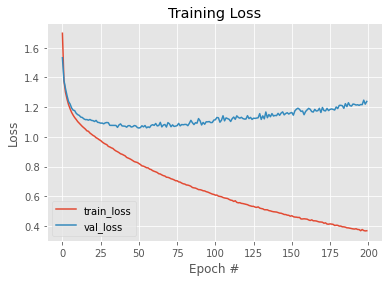

In [ ]:
plot_training_loss(history)

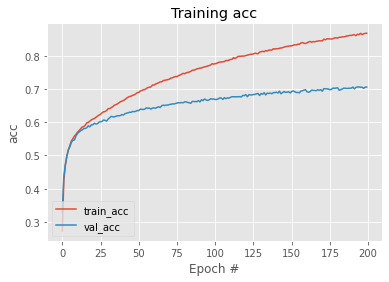

In [ ]:
plot_training_acc(history)